In [40]:
# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [41]:
# --- 2. Define Data File Paths ---

# Using constants for file paths makes the script organized and easy to update.
OCT_DATA_PATH = '/Users/selim/Desktop/Projects/Python Projects/E-Commerce Customer Intelligence/datas/raw/2019-Oct.csv'
NOV_DATA_PATH = '/Users/selim/Desktop/Projects/Python Projects/E-Commerce Customer Intelligence/datas/raw/2019-Nov.csv'

In [42]:
# --- 3. Load and Concatenate Data ---

# Load the individual CSV files for October and November.
try:
    df_oct = pd.read_csv(OCT_DATA_PATH)
    df_nov = pd.read_csv(NOV_DATA_PATH)
except FileNotFoundError as e:
    print(f"Error: One of the data files was not found. Please check the paths.")
    print(e)
    # Exit the script if data cannot be loaded.
    exit()

# Combine the two monthly DataFrames into a single, comprehensive DataFrame.
# `ignore_index=True` creates a new, continuous index for the combined data.
df = pd.concat([df_oct, df_nov], ignore_index=True)

print("Data for October and November loaded and combined successfully.")

Data for October and November loaded and combined successfully.


In [43]:
# --- 4. Initial Data Type Conversion ---

# Convert the 'event_time' column to a proper datetime format.
# `utc=True` standardizes the timestamps to Coordinated Universal Time.
# `errors='coerce'` will replace any unparseable dates with NaT (Not a Time).
df['event_time'] = pd.to_datetime(df['event_time'], utc=True, errors='coerce')

In [44]:
# --- 5. Verify the Loaded Data ---

# Display the first few rows to get an overview of the data.
print("\n--- DataFrame Head ---")
print(df.head())

# Display a summary of the DataFrame to check data types and null values.
# This is a crucial step to verify that the loading and initial conversion worked as expected.
print("\n--- DataFrame Info ---")
df.info()


--- DataFrame Head ---
                 event_time event_type  product_id          category_id  \
0 2019-10-01 00:00:00+00:00       view    44600062  2103807459595387724   
1 2019-10-01 00:00:00+00:00       view     3900821  2053013552326770905   
2 2019-10-01 00:00:01+00:00       view    17200506  2053013559792632471   
3 2019-10-01 00:00:01+00:00       view     1307067  2053013558920217191   
4 2019-10-01 00:00:04+00:00       view     1004237  2053013555631882655   

                         category_code     brand    price    user_id  \
0                                  NaN  shiseido    35.79  541312140   
1  appliances.environment.water_heater      aqua    33.20  554748717   
2           furniture.living_room.sofa       NaN   543.10  519107250   
3                   computers.notebook    lenovo   251.74  550050854   
4               electronics.smartphone     apple  1081.98  535871217   

                           user_session  
0  72d76fde-8bb3-4e00-8c23-a032dfed738c  
1  9333d

## 1. RFM (Recency, Frequency, Monetary) Customer Segmentation


### Business Question: Can we segment our customer base into distinct groups based on their purchasing behavior to tailor our marketing efforts and increase repeat purchases?


#### Required Columns: user_id, event_time, price.


In [45]:
# --- 1.1 Initial Data Preparation for RFM ---

# Filter for purchase events only and select the necessary columns.
rfm_df = df[df['event_type'] == 'purchase'][['user_id', 'event_time', 'price']].copy()

# Determine the last transaction date in the dataset to calculate recency from.
last_date = rfm_df['event_time'].max()
print(f"Analysis is based on data up to: {last_date.date()}")

Analysis is based on data up to: 2019-11-30


In [46]:
# --- 1.2 Recency (R) Analysis ---

# Calculate the time since each user's last purchase.
recency_df = rfm_df.groupby('user_id')['event_time'].max().reset_index()
recency_df['recency'] = (last_date - recency_df['event_time']).dt.days

# Define bins and labels for recency categories.
bins_recency = [0, 12, 20, 39, np.inf]
labels_recency = ['Very Recent (<2 weeks)', 'Recent (2-4 weeks)', 'Not Recent (4-6 weeks)', 'At Risk (>6 weeks)']

# Create a summary of users in each recency category.
recency_summary = recency_df.copy()
recency_summary['category'] = pd.cut(recency_summary['recency'], bins=bins_recency, labels=labels_recency, include_lowest=True)
recency_summary = recency_summary.groupby('category')[['user_id']].count()
recency_summary['percent'] = (recency_summary['user_id'] / rfm_df['user_id'].nunique() * 100).round(2)

/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_30952/3113974185.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  recency_summary = recency_summary.groupby('category')[['user_id']].count()


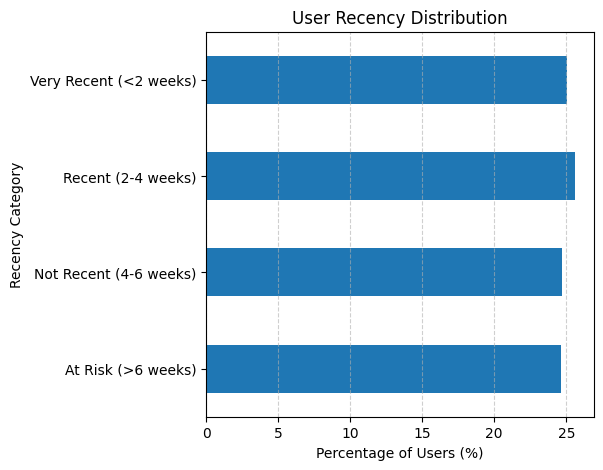

,user_id,percent
category,,
Very Recent (<2 weeks),174741,25.05
Recent (2-4 weeks),178623,25.61
Not Recent (4-6 weeks),172490,24.73
At Risk (>6 weeks),171616,24.61


In [47]:
# --- Plot: User Distribution by Recency ---
recency_summary['percent'].iloc[::-1].plot(
    kind='barh',
    figsize=(5, 5),
    title='User Recency Distribution',
    xlabel='Percentage of Users (%)',
    ylabel='Recency Category'
)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

recency_summary

In [77]:
# --- 1.3 Frequency (F) Analysis ---

# Calculate the number of purchases for each user.
frequency_df = rfm_df.groupby('user_id')[['event_time']].agg(frequency = ('event_time','count')).reset_index()

# Define bins and labels for frequency categories.
bins_frequency = [0, 1, 3, 10, np.inf]
labels_frequency = ['One-time (1)', 'Occasional (2-3)', 'Frequent (4-10)', 'Very Frequent (>10)']

# Create a summary of users in each frequency category.
frequency_summary = frequency_df.copy()
frequency_summary['category'] = pd.cut(frequency_summary['frequency'], bins=bins_frequency, labels=labels_frequency, include_lowest=True)
frequency_summary = frequency_summary.groupby('category')[['user_id']].count()
frequency_summary['percent'] = (frequency_summary['user_id'] / rfm_df['user_id'].nunique() * 100).round(2)

/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_30952/2539895965.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  frequency_summary = frequency_summary.groupby('category')[['user_id']].count()


In [78]:

# Define bins and labels for frequency categories.
bins_frequency = [0, 1, 3, 10, np.inf]
labels_frequency = ['One-time (1)', 'Occasional (2-3)', 'Frequent (4-10)', 'Very Frequent (>10)']

# Create a summary of users in each frequency category.
frequency_summary = frequency_df.copy()
frequency_summary['category'] = pd.cut(frequency_summary['frequency'], bins=bins_frequency, labels=labels_frequency, include_lowest=True)
frequency_summary = frequency_summary.groupby('category')[['user_id']].count()
frequency_summary['percent'] = (frequency_summary['user_id'] / rfm_df['user_id'].nunique() * 100).round(2)

/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_30952/1541408846.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  frequency_summary = frequency_summary.groupby('category')[['user_id']].count()


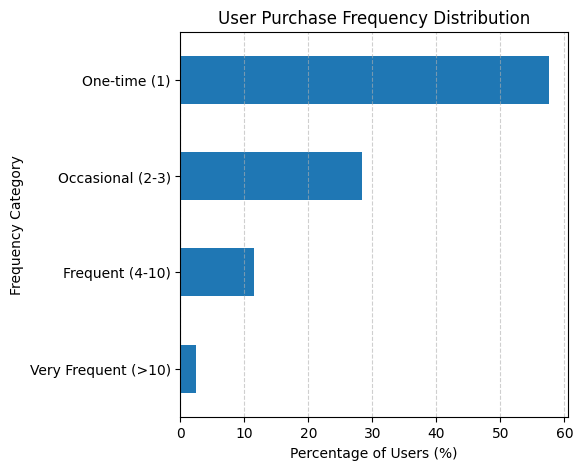

,user_id,percent
category,,
One-time (1),402145,57.66
Occasional (2-3),198101,28.40
Frequent (4-10),80447,11.53
Very Frequent (>10),16777,2.41


In [79]:
# --- Plot: User Distribution by Frequency ---
frequency_summary['percent'].iloc[::-1].plot(
    kind='barh',
    figsize=(5, 5),
    title='User Purchase Frequency Distribution',
    xlabel='Percentage of Users (%)',
    ylabel='Frequency Category'
)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

frequency_summary

In [51]:
# --- 1.4 Monetary (M) Analysis ---

# Calculate the total spending for each user.
monetary_df = rfm_df.groupby('user_id')['price'].sum().reset_index()

# Define bins and labels for monetary categories.
bins_monetary = [0, 120, 260, 700, np.inf]
labels_monetary = ['Low Spender (<120)', 'Mid Spender (120-260)', 'High Spender (260-700)', 'Premium Spender (>700)']

# Create a summary of users in each monetary category.
monetary_summary = monetary_df.copy()
monetary_summary['category'] = pd.cut(monetary_summary['price'], bins=bins_monetary, labels=labels_monetary, include_lowest=True)
monetary_summary = monetary_summary.groupby('category')[['user_id']].count()
monetary_summary['percent'] = (monetary_summary['user_id'] / rfm_df['user_id'].nunique() * 100).round(2)

/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_30952/1057602105.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monetary_summary = monetary_summary.groupby('category')[['user_id']].count()


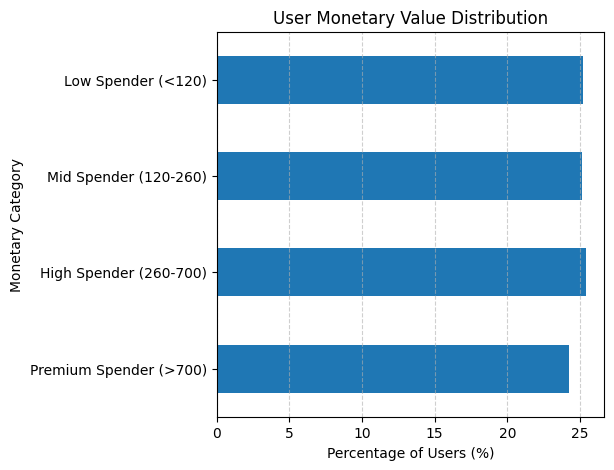

,user_id,percent
category,,
Low Spender (<120),175854,25.21
Mid Spender (120-260),175432,25.15
High Spender (260-700),177049,25.38
Premium Spender (>700),169135,24.25


In [52]:
# --- Plot: User Distribution by Monetary Value ---
monetary_summary['percent'].iloc[::-1].plot(
    kind='barh',
    figsize=(5, 5),
    title='User Monetary Value Distribution',
    xlabel='Percentage of Users (%)',
    ylabel='Monetary Category'
)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

monetary_summary

In [53]:
# --- 1.5 RFM Score Calculation ---

# Assign numerical scores for each R, F, and M value.
# Note: Recency is inverted (lower is better), so more recent users get a higher score (4).
recency_df['recency_score'] = pd.cut(recency_df['recency'], bins=bins_recency, labels=[4, 3, 2, 1], include_lowest=True)
frequency_df['frequency_score'] = pd.cut(frequency_df['frequency'], bins=bins_frequency, labels=[1, 2, 3, 4], include_lowest=True)
monetary_df['monetary_score'] = pd.cut(monetary_df['price'], bins=bins_monetary, labels=[1, 2, 3, 4], include_lowest=True)

# Merge the R, F, and M DataFrames to create a single segmentation table.
rfm_scores = pd.merge(recency_df[['user_id', 'recency_score']], frequency_df[['user_id', 'frequency_score']], on='user_id')
rfm_scores = pd.merge(rfm_scores, monetary_df[['user_id', 'monetary_score']], on='user_id')

# Calculate the total RFM score by summing the individual scores.
rfm_scores['rfm_score'] = rfm_scores['recency_score'].astype(int) + rfm_scores['frequency_score'].astype(int) + rfm_scores['monetary_score'].astype(int)

In [54]:
# --- 1.6 Final RFM Segmentation ---

# Define a function to map RFM scores to named segments.
def assign_rfm_segment(score):
    if score >= 10:
        return 'Champion'
    elif score >= 7:
        return 'Loyal'
    elif score >= 5:
        return 'Potential'
    else:
        return 'At Risk'

# Apply the function to create the final segment for each user.
rfm_scores['rfm_segment'] = rfm_scores['rfm_score'].apply(assign_rfm_segment)

# Convert the segment column to a categorical type for ordered plotting.
segment_order = ['Champion', 'Loyal', 'Potential', 'At Risk']
rfm_scores['rfm_segment'] = pd.Categorical(rfm_scores['rfm_segment'], categories=segment_order, ordered=True)

# Create a final summary table of the customer segments.
segmentation_summary = rfm_scores.groupby('rfm_segment')[['user_id']].count()
segmentation_summary['percent'] = (segmentation_summary['user_id'] / rfm_df['user_id'].nunique() * 100).round(2)

/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_30952/2358631533.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segmentation_summary = rfm_scores.groupby('rfm_segment')[['user_id']].count()


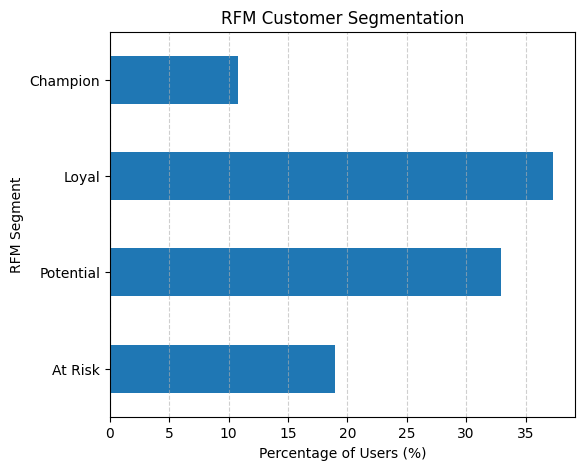

,user_id,percent
rfm_segment,,
Champion,75445,10.82
Loyal,260076,37.29
Potential,229498,32.90
At Risk,132451,18.99


In [55]:
# --- Plot: Final RFM Customer Segmentation ---
segmentation_summary['percent'].iloc[::-1].plot(
    kind='barh',
    figsize=(6, 5),
    title='RFM Customer Segmentation',
    xlabel='Percentage of Users (%)',
    ylabel='RFM Segment'
)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

segmentation_summary

## 2. Market Basket Analysis for Cross-Selling Opportunities

### Business Question: Which product categories and brands are most frequently purchased together within a single user session, and can we leverage this insight to increase our average order value?


#### Required Columns: user_session, product_id, category_code, brand.

In [56]:
# --- 2.1 Data Preparation ---

# Filter for purchase events and select relevant columns.
cross_analysis_df = df[df['event_type'] == 'purchase'][['user_session', 'product_id', 'category_code', 'brand']].copy()

# Drop rows where 'category_code' or 'brand' are missing, as they are crucial for this analysis.
cross_analysis_df.dropna(subset=['category_code', 'brand'], inplace=True)

# Create a 'product_label' by combining category and brand for a unique identifier.
cross_analysis_df['product_label'] = cross_analysis_df['category_code'].astype(str) + ' | ' + cross_analysis_df['brand'].astype(str)

In [57]:
# --- 2.2 Identify Transactions with Multiple Products ---

# Create a DataFrame of all transactions, mapping session IDs to product labels.
transactions = cross_analysis_df[['user_session', 'product_label']]

# Identify user sessions that contain at least two different products (potential for cross-selling).
session_counts = transactions.groupby('user_session')['product_label'].nunique()
multi_item_sessions = session_counts[session_counts >= 2].index

# Filter the transactions to include only these multi-item sessions.
transactions = transactions[transactions['user_session'].isin(multi_item_sessions)]

In [58]:
# --- 2.3 Generate and Standardize Product Pairs ---

# Perform a self-merge on 'user_session' to create all possible combinations of products bought in the same session.
pairs = pd.merge(transactions, transactions, on='user_session', suffixes=('_a', '_b'))

# Remove rows where a product is paired with itself.
pairs = pairs[pairs['product_label_a'] != pairs['product_label_b']]

# Create a canonical representation for each pair to avoid duplicates.
# ('A', 'B') will be treated the same as ('B', 'A') by sorting alphabetically.
pairs['prd_a'] = pairs[['product_label_a', 'product_label_b']].min(axis=1)
pairs['prd_b'] = pairs[['product_label_a', 'product_label_b']].max(axis=1)

# Keep only the unique canonical pairs for each session.
unique_pairs_per_session = pairs[['user_session', 'prd_a', 'prd_b']].drop_duplicates()

In [59]:
# --- 2.4 Aggregate and Analyze Pair Frequencies ---

# Group by the canonical pairs and count how many unique sessions each pair appears in.
# Sort to find the most frequently co-purchased pairs.
pair_counts = unique_pairs_per_session.groupby(['prd_a', 'prd_b']).size().reset_index(name='session_count')
pair_counts = pair_counts.sort_values('session_count', ascending=False)

# Calculate the percentage of total unique purchase sessions that contain each pair.
total_purchase_sessions = cross_analysis_df['user_session'].nunique()
pair_counts['percent'] = (pair_counts['session_count'] / total_purchase_sessions * 100).round(2)

/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_30952/4274238323.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_pairs['pair_label'] = top_pairs['prd_a'] + '\n& ' + top_pairs['prd_b']


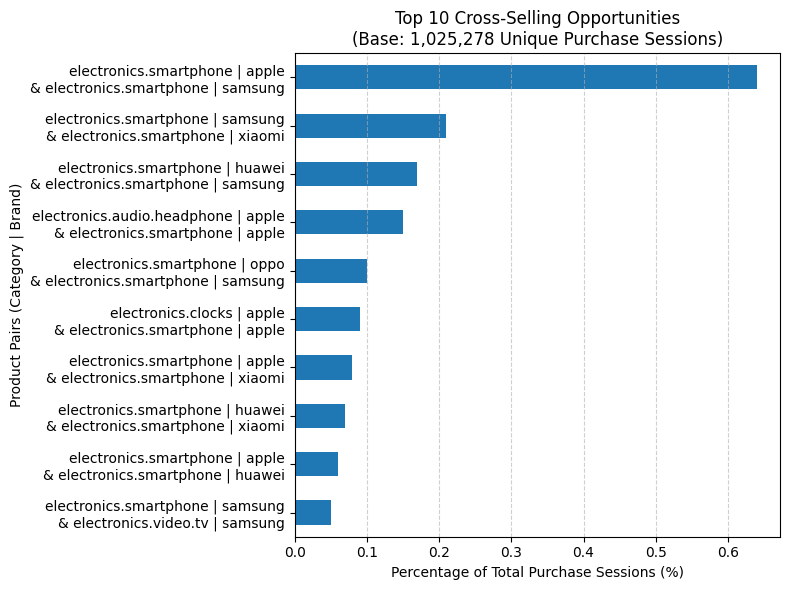

,prd_a,prd_b,session_count,percent,pair_label
13490,electronics.smartphone | apple,electronics.smartphone | samsung,6586,0.64,electronics.smartphone | apple\n& electronics....
13915,electronics.smartphone | samsung,electronics.smartphone | xiaomi,2115,0.21,electronics.smartphone | samsung\n& electronic...
13689,electronics.smartphone | huawei,electronics.smartphone | samsung,1759,0.17,electronics.smartphone | huawei\n& electronics...
12423,electronics.audio.headphone | apple,electronics.smartphone | apple,1497,0.15,electronics.audio.headphone | apple\n& electro...
13841,electronics.smartphone | oppo,electronics.smartphone | samsung,1011,0.10,electronics.smartphone | oppo\n& electronics.s...
13192,electronics.clocks | apple,electronics.smartphone | apple,940,0.09,electronics.clocks | apple\n& electronics.smar...
13495,electronics.smartphone | apple,electronics.smartphone | xiaomi,838,0.08,electronics.smartphone | apple\n& electronics....
13696,electronics.smartphone | huawei,electronics.smartphone | xiaomi,698,0.07,electronics.smartphone | huawei\n& electronics...
13481,electronics.smartphone | apple,electronics.smartphone | huawei,621,0.06,electronics.smartphone | apple\n& electronics....
13955,electronics.smartphone | samsung,electronics.video.tv | samsung,532,0.05,electronics.smartphone | samsung\n& electronic...


In [60]:
# --- 2.5 Visualize Top Cross-Selling Opportunities ---

# Select the top 10 most frequent pairs for visualization.
top_n = 10
top_pairs = pair_counts.head(top_n)

# Create a more readable label for the y-axis of the plot.
top_pairs['pair_label'] = top_pairs['prd_a'] + '\n& ' + top_pairs['prd_b']

top_pairs.sort_values('percent', ascending=True).plot(
    kind='barh',
    x='pair_label',
    y='percent',
    figsize=(8, 6),
    legend=False,
    title=f'Top {top_n} Cross-Selling Opportunities\n(Base: {total_purchase_sessions:,} Unique Purchase Sessions)',
    xlabel='Percentage of Total Purchase Sessions (%)',
    ylabel='Product Pairs (Category | Brand)'
)
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# Display the top 10 pairs data for review.
top_pairs

# 3. Purchase Cadence and Timing Analysis


### Business Question: What is the typical time between purchases for our repeat customers, and are there specific days of the week or times of the day when purchasing activity peaks?


#### Required Columns: user_id, event_time.


In [61]:
# --- 3.1 Purchase Cadence Analysis (Time Between Repeat Purchases) ---

# --- Data Preparation for Cadence ---
# Filter for purchase events and sort by user and time to prepare for interval calculation.
cadence_df = df[df['event_type'] == 'purchase'][['user_id', 'event_time']].sort_values(['user_id', 'event_time'])

# Calculate the time difference between consecutive purchases for each user.
# The .diff() function calculates the difference between an element and the previous element in a group.
time_between_purchases = cadence_df.groupby('user_id')[['event_time']].diff()

# Convert the resulting timedelta objects to a more readable unit (hours).
# We drop NaT values, which represent the first purchase of each user (no prior event).
time_between_purchases.dropna(inplace=True)
time_between_purchases['hours_between'] = (time_between_purchases['event_time'].dt.total_seconds() / 3600).round(2)

In [62]:
# --- Categorization and Distribution ---
# Define bins and labels to categorize the time intervals.
bins_cadence = [0, 0.5, 24, 168, 336, 720, np.inf]
labels_cadence = [
    "Split Order (<30m)",
    "Same Day (30m-24h)",
    "Weekly (1-7d)",
    "Bi-Weekly (1-2w)",
    "Monthly (2-4w)",
    "Long Term (>4w)"
]

# Assign each purchase interval to a category.
time_between_purchases['cadence_category'] = pd.cut(time_between_purchases['hours_between'], bins=bins_cadence, labels=labels_cadence, include_lowest=True)

# Calculate the percentage distribution of these cadence categories.
cadence_distribution = pd.DataFrame((time_between_purchases['cadence_category'].value_counts(normalize=True) * 100).round(2))
cadence_distribution.columns = ['percentage']

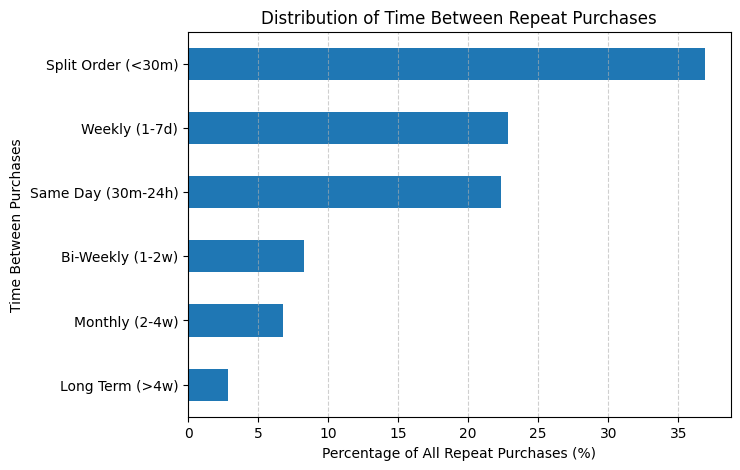

,percentage
cadence_category,
Split Order (<30m),36.89
Weekly (1-7d),22.87
Same Day (30m-24h),22.33
Bi-Weekly (1-2w),8.30
Monthly (2-4w),6.75
Long Term (>4w),2.86


In [63]:
# --- Plot: Distribution of Purchase Cadence ---
cadence_distribution.sort_values('percentage', ascending=True).plot(
    kind='barh',
    legend=False,
    figsize=(7, 5),
    title='Distribution of Time Between Repeat Purchases',
    xlabel='Percentage of All Repeat Purchases (%)',
    ylabel='Time Between Purchases'
)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

cadence_distribution

In [64]:
# --- 3.2 Purchase Timing Analysis (Day and Hour) ---

# --- Data Preparation for Timing ---
# Create a focused DataFrame with only the event times of purchases.
timing_df = df[df['event_type'] == 'purchase'][['event_time']].copy()

# --- Analysis by Day of the Week ---
timing_df['day_of_week'] = timing_df['event_time'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
timing_df['day_of_week'] = pd.Categorical(timing_df['day_of_week'], categories=days_order, ordered=True)

# Calculate the percentage distribution of purchases across the days of the week.
day_distribution = pd.DataFrame((timing_df['day_of_week'].value_counts(normalize=True).sort_index() * 100).round(2))
day_distribution.columns = ['percentage']

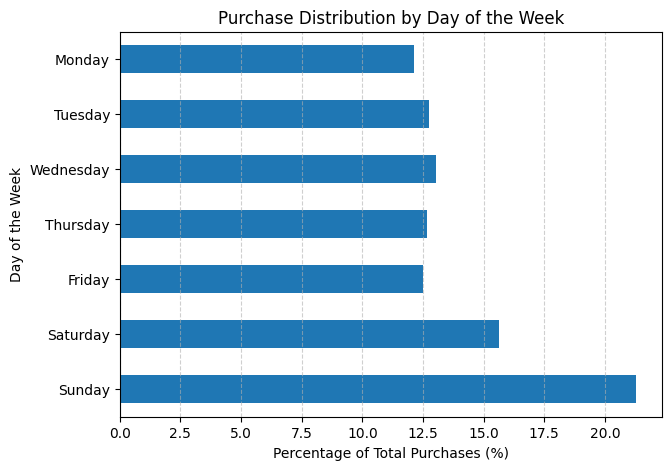

,percentage
day_of_week,
Monday,12.12
Tuesday,12.73
Wednesday,13.04
Thursday,12.67
Friday,12.50
Saturday,15.63
Sunday,21.30


In [65]:
# --- Plot: Purchases by Day of the Week ---
day_distribution.iloc[::-1].plot(
    kind='barh',
    legend=False,
    figsize=(7, 5),
    title='Purchase Distribution by Day of the Week',
    xlabel='Percentage of Total Purchases (%)',
    ylabel='Day of the Week'
)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

day_distribution

In [66]:
# --- Analysis by Hour of the Day ---
timing_df['hour_of_day'] = timing_df['event_time'].dt.hour

# Calculate the percentage distribution of purchases across the hours of the day.
hour_distribution = pd.DataFrame((timing_df['hour_of_day'].value_counts(normalize=True).sort_index() * 100).round(2))
hour_distribution.columns = ['percentage']

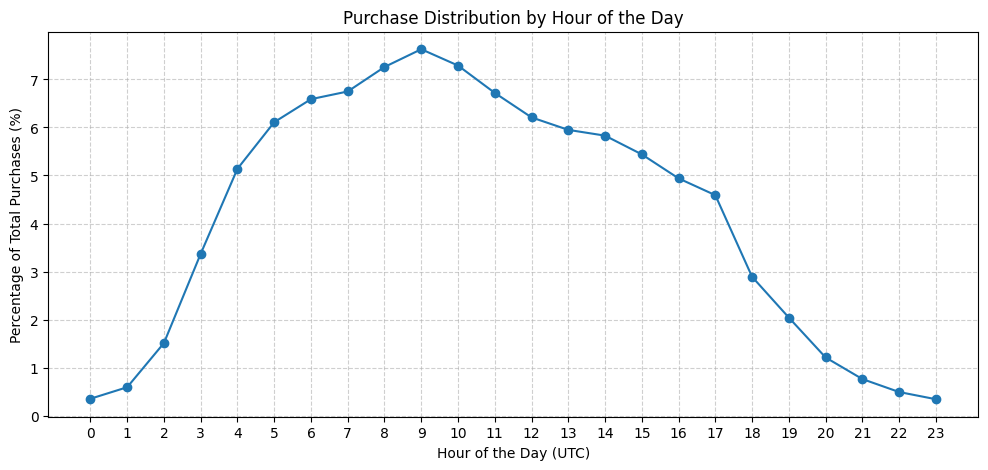

,percentage
hour_of_day,
0,0.35
1,0.59
2,1.51
3,3.37
4,5.14
5,6.11
6,6.59
7,6.75
8,7.26


In [67]:
# --- Plot: Purchases by Hour of the Day ---
hour_distribution.plot(
    kind='line',
    legend=False,
    figsize=(12, 5),
    title='Purchase Distribution by Hour of the Day',
    xlabel='Hour of the Day (UTC)',
    ylabel='Percentage of Total Purchases (%)',
    marker='o'
)
plt.xticks(np.arange(0, 24, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

hour_distribution

# 4. Brand Loyalty and its Impact on Customer Value


### Business Question: Do customers who consistently purchase from the same brand exhibit a higher lifetime value compared to those who shop across multiple brands?


#### Required Columns: user_id, brand, price, event_time.


In [68]:
# --- 4.1 Data Preparation and Metric Aggregation ---

# Import the seaborn library for advanced visualizations.
import seaborn as sns

# Start with a clean base of purchase data, dropping rows where 'brand' is missing.
df_purchases = df[df['event_type'] == 'purchase'].dropna(subset=['brand']).copy()

# Aggregate key metrics for each user.
# - brand_count: The number of unique brands a user has purchased from.
# - ltv: The lifetime value, calculated as the sum of all their purchases.
# - frequency: The total number of purchases made by the user.
user_metrics = df_purchases.groupby('user_id').agg(
    brand_count=('brand', 'nunique'),
    ltv=('price', 'sum'),
    frequency=('event_time', 'count')
)

In [69]:
# --- 4.2 Customer Segmentation by Loyalty ---

# For a fair comparison of loyalty, focus only on repeat customers (those with 2 or more purchases).
repeat_customers = user_metrics[user_metrics['frequency'] >= 2].copy()

# Segment these customers into two groups based on their brand purchasing behavior.
repeat_customers['loyalty_type'] = repeat_customers['brand_count'].apply(
    lambda x: 'Single-Brand Loyalist' if x == 1 else 'Multi-Brand Shopper'
)

In [70]:
# --- 4.3 Compare LTV Between Segments ---

# Display a numerical summary to complement the visual plot.
print("--- LTV Summary by Customer Loyalty Type ---")
ltv_summary = repeat_customers.groupby('loyalty_type')['ltv'].describe()
print(ltv_summary)

--- LTV Summary by Customer Loyalty Type ---
                          count         mean          std  min      25%  \
loyalty_type                                                              
Multi-Brand Shopper    166317.0  1499.613646  4004.199256  3.0  282.150   
Single-Brand Loyalist  105471.0  1230.613678  2388.878927  2.0  286.105   

                          50%      75%        max  
loyalty_type                                       
Multi-Brand Shopper    625.35  1430.52  344153.29  
Single-Brand Loyalist  561.42  1420.11  265569.52  


/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_30952/2281553460.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


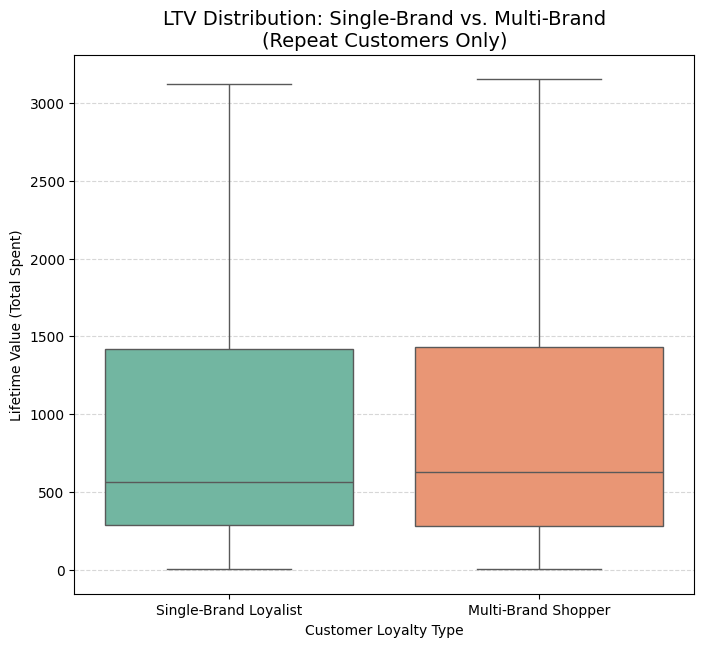

In [71]:
# --- Plot: LTV Distribution by Loyalty Type ---
# A boxplot is an excellent choice to compare the distribution (median, quartiles) of a value across different categories.
plt.figure(figsize=(8, 7)) # Adjusted size for better readability

sns.boxplot(
    x='loyalty_type',
    y='ltv',
    data=repeat_customers,
    showfliers=False, # Hides outliers to focus on the main distribution of LTV
    palette='Set2'
)

plt.title('LTV Distribution: Single-Brand vs. Multi-Brand\n(Repeat Customers Only)', fontsize=14)
plt.ylabel('Lifetime Value (Total Spent)')
plt.xlabel('Customer Loyalty Type')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()